<center><img src="images/header.png"></center>

<h1><center>Алгоритмы интеллектуальной обработки больших объемов данных</center></h1>
<hr>
<h2><center>Деревья решений, случайные леса (практика)</center></h2>

**Срок сдачи:** 3 апреля 2017, 06:00 <br> 
**Штраф за опоздание:** -2 балла после 06:00 3 апреля, -4 балла после 06:00 10 апреля, -6 баллов после 06:00 17 апреля

При отправлении ДЗ указывайте фамилию в названии файла<br>

Не забудте создать задание в Slack через /todo.

Используйте данный Ipython Notebook при оформлении домашнего задания.

In [141]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,8)

# Для кириллицы на графиках
font = {'family': 'Verdana',
        'weight': 'normal'}
plt.rc('font', **font)

# Практика

### Качество вина (10 баллов)

Давайте все-таки разберемся с [вином](https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv)!


#### Задание (1 балл)
* Загрузите данные, выполните преобразование целевой переменной: 
    * quality > 5 -> 1
    * quality <= 5 -> 0
* Разделите выборку на обучающую и контрольную в пропорции 80/20

In [5]:
from tqdm import tqdm_notebook

ImportError: No module named 'tqdm'

In [142]:
df_wine = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv', sep=';')

In [143]:
df_wine.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [144]:
df_wine.loc[:, 'quality'] = (df_wine.loc[:, 'quality'] > 5).astype(int)

In [145]:
X, y = df_wine.iloc[:, :-1].values, df_wine.iloc[:, -1].values

In [146]:
from sklearn.model_selection import train_test_split

In [147]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

#### Задание (2 балла)

Сфокусируемся на одном гиперпараметре деревьев решений - максимальной глубине.

Подберите наилучшую глубину `d` дерева с помошью 
* Усредненной оценки качества roc-auc на кросс-валидации при различных `d`
* Валидационных кривых

In [149]:
from sklearn.tree import DecisionTreeClassifier

try:
    from sklearn.model_selection import cross_val_score
except ImportError:
    from sklearn.cross_validation import cross_val_score

try:
    from sklearn.model_selection import validation_curve
except ImportError:
    from sklearn.learning_curve import validation_curve

In [150]:
scores = []

for d in range(1, 20):
    model = DecisionTreeClassifier(max_depth=d, random_state=123)
    scores.append(cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc').mean())

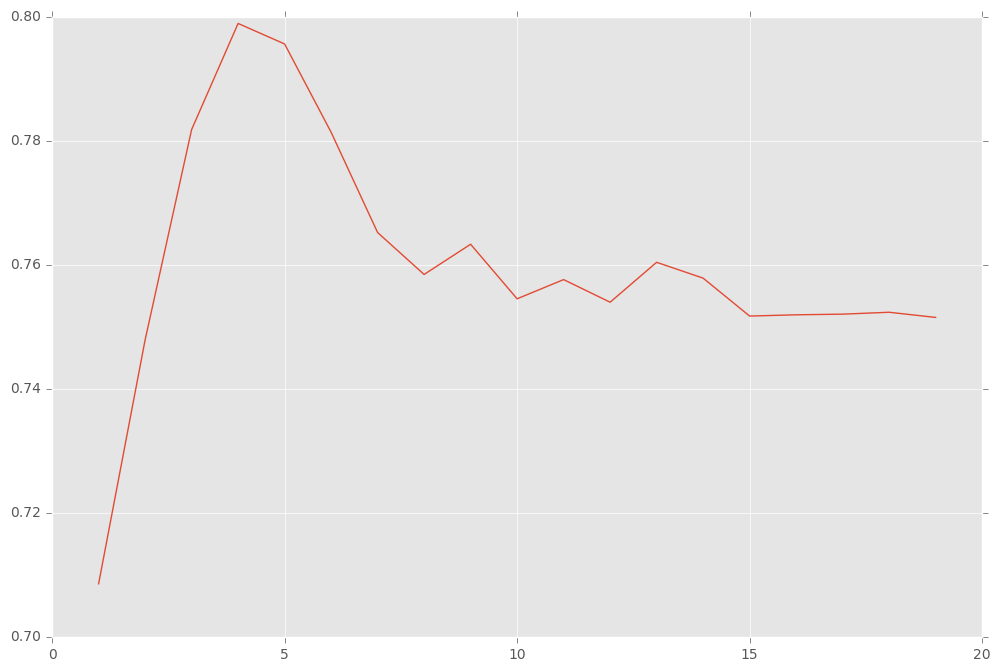

In [151]:
plt.plot(range(1,20), scores)

In [46]:
# При мере качества roc-auc виден явный пик на глубине 4
# Если выбрать меру качества accuracy, то выбрать оптимальную глубину окажется не так просто.

# Воспользуемся validation_curve
# По сути - этот метод делает тоже самое что наш цикл с cross_val_score, но в результате возвращаются мера качества
# как на тестовой части каждого из фолдов, так и на обучающей части

In [152]:
model = DecisionTreeClassifier(random_state=123)
train_scores, test_scores = validation_curve(model, X_train, y_train, 'max_depth',
                                             range(1, 20), n_jobs=-1, cv=5, scoring='roc_auc')

In [153]:
train_mean = train_scores.mean(axis=1)
test_mean = test_scores.mean(axis=1)
train_std = train_scores.std(axis=1)
test_std = test_scores.std(axis=1)

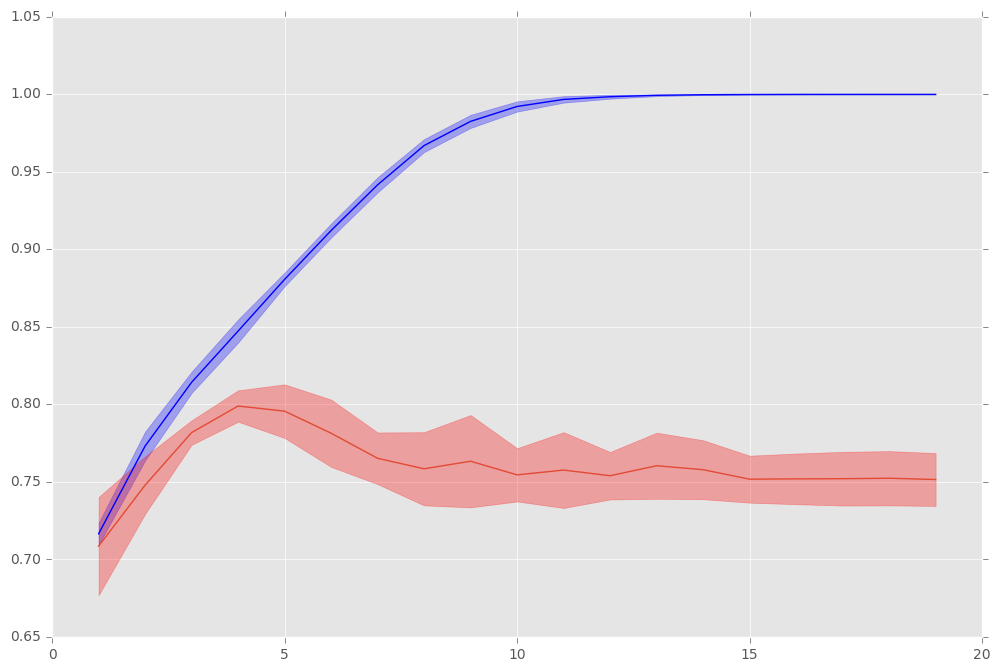

In [154]:
d = range(1,20)
plt.plot(d, train_mean, color='b')
plt.plot(d, test_mean)

plt.fill_between(d, train_mean-train_std, train_mean+train_std, color='b', alpha=0.3)
plt.fill_between(d, test_mean-test_std, test_mean+test_std, color='r', alpha=0.3)

In [50]:
# При roc-auc видем тот же самый пик
# Если выбрать меру качества accuracy, то на той глубине, где accuracy был наибольший (где-то в районе 13) ошибка на 
# на трейновой части минимальная - то есть очень сильное переобучение.

# Основываясь, во-первых, на том, что по roc-auc виден пик при max_depth=4, и во-вторых на том, что переобучение по 
# accuracy не такое сильное при max_depth=4, а качество будет повыше, чем в окрестности, то я бы выбрал глубину = 4

#### Задание (1 балл)

Отсортируйте признаки по важности. Вектор с важностью признаков можно получить с помощью `model.feature_importances_`

In [155]:
# Your Code Here
model = DecisionTreeClassifier(max_depth = 4)
model.fit(X_train, y_train)
imp = model.feature_importances_ 
imp

array([ 0.        ,  0.12647937,  0.        ,  0.        ,  0.        ,
        0.05226398,  0.05471579,  0.01356353,  0.01781177,  0.16057994,
        0.57458562])

Видно, что наибольший вклад вносят признаки volatile acidity, sulphate, alcohol

#### Задание (2 балла)
* Получите предсказания на тестовой выборке
* Постройте ROC кривые для обучающей и тестовой выборок
* Посчитайте остальные меры качества классификации при пороге в `0.5`

#не сделано

#### Задание (1 балл)
Перейдем к модели случайного леса. Зафиксируем некоторую глубину дерева (можно звять оптимальное с предыдущих заданий).

Сравните качество работы 
* Простого дерева решений
* Бэггинга над 10,20,...,100 деревьями решений
* Случайного леса с 10,20,...,100 деревьями решений

Получите график, у которого по оси X откладывается количество деревьев, а по оси Y - качество классификации.

In [156]:
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier

In [157]:
# Your Code Here
scores_1 = []
scores_2 = []
scores_3 = []
for i in range(10, 110, 10):
    bag = BaggingClassifier(base_estimator = DecisionTreeClassifier(max_depth=5, random_state=123),
                        n_estimators=i,
                        max_samples=0.7,
                        max_features= 0.7,
                        bootstrap_features=True)
    
    rfr = RandomForestClassifier(n_estimators = i, max_depth = 5)
    dtc = DecisionTreeClassifier(max_depth=i//10, random_state=123)
    scores_1.append(cross_val_score(bag, X_train, y_train, cv=5, scoring='roc_auc').mean())
    scores_2.append(cross_val_score(rfr, X_train, y_train, cv=5, scoring='roc_auc').mean())
    scores_3.append(cross_val_score(dtc, X_train, y_train, cv=5, scoring='roc_auc').mean())



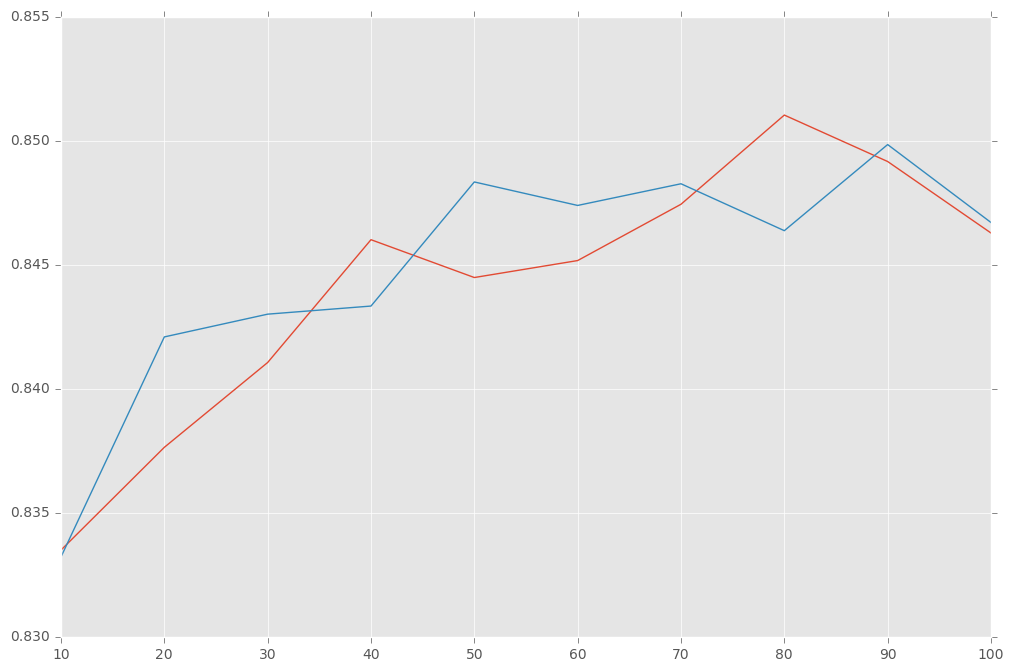

In [158]:
#Графики качества классификации при разных параметров и при разных алгоритмов
plt.plot(range(10, 110, 10), scores_1)
plt.plot(range(10, 110, 10), scores_2)


    

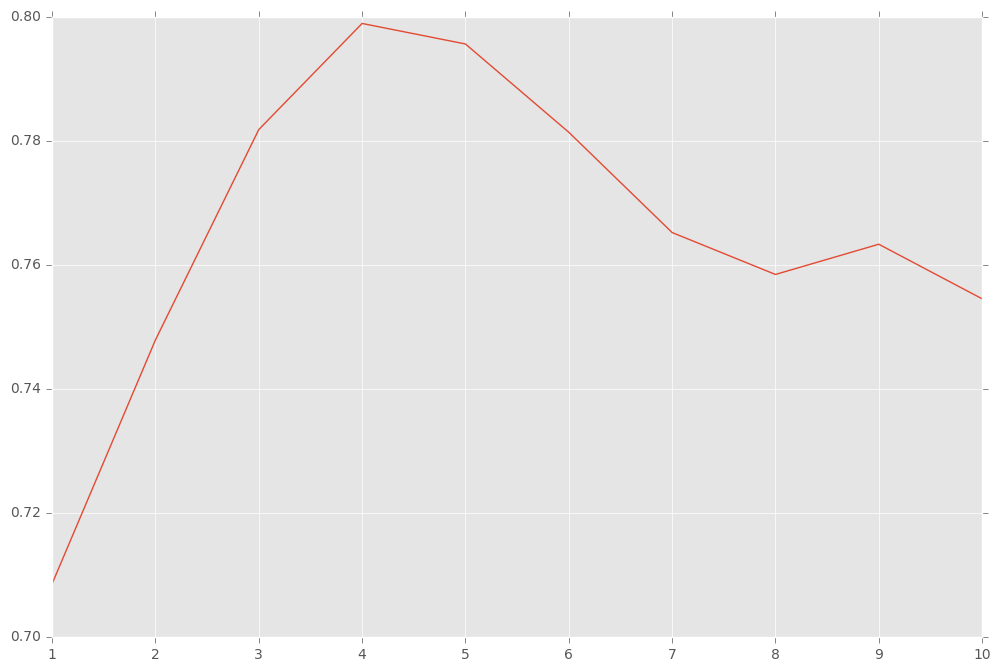

In [159]:
plt.plot(range(1, 11), scores_3)


####  Задание (3 балла)
* С помощью `GridSearchCV` или `RandomSearchCV` подберите наиболее оптимальные параметры для случайного леса.
* Для этих параметров сравните средние результаты по кросс-валидации и качество на контрольной выборке

In [161]:
# Your Code Here
from sklearn.model_selection import GridSearchCV
rfr = RandomForestClassifier(random_state = 123)

param_grid = [
  {'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80], 'max_depth': [3,4,5,6,7,8,9,10,11,12,13,14,15,16,17]}
 ]

param_grid
clf = GridSearchCV(rfr, param_grid, cv=5, scoring='roc_auc')
clf.fit(X_train, y_train)


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=123,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80], 'max_depth': [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=0)

In [163]:
# Видно, что самые лучшие параметры - это когда количество деревьев равно 80, а максимальная глубина дерева равна 16
clf.best_estimator_
best_parametrs = clf.best_estimator_.get_params()
best_parametrs



{'bootstrap': True,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': 16,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_split': 1e-07,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 80,
 'n_jobs': 1,
 'oob_score': False,
 'random_state': 123,
 'verbose': 0,
 'warm_start': False}

In [167]:
score_rfr_train = []
model = RandomForestClassifier(max_depth = 16, n_estimators = 80)
score_rfr_train.append(cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc').mean())
score_rfr_train

[0.88952720794200035]

In [168]:
from sklearn.metrics import roc_auc_score, accuracy_score
model.fit(X_train, y_train)
y_predict = model.predict_proba(X_test)
roc_auc_score(y_test_bin, y_predict[:,1])


0.87873891625615752

Получается, что качество на контрольной выборке равно 0.87, а средняя на кросс-валидации 0.89